# Inicio y carga de datos

In [ ]:
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from branca.colormap import linear
import json
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
from difflib import get_close_matches
from IPython.display import display, HTML

In [ ]:
pd.options.display.max_columns = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1sjcx1kAsGBZFXOodOVISw0Om1xv4cPfe -O Pump_initial_data.csv
!gdown 189yoGaH9RP-6beuEt7Hs0JD6ew5qnxQw -O altitudes.csv
!gdown 1x8SjCezfpSRLFLq_gUdFF7LtgTg63Cnn -O population_data.xlsx
!gdown 1RHCTLg0ZhIKWvhgIQ9_SNQB_d3EOY9Cy -O gdp_per_capita.csv



Downloading...
From: https://drive.google.com/uc?id=1sjcx1kAsGBZFXOodOVISw0Om1xv4cPfe
To: /content/Pump_initial_data.csv
100% 20.8M/20.8M [00:00<00:00, 53.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=189yoGaH9RP-6beuEt7Hs0JD6ew5qnxQw
To: /content/altitudes.csv
100% 8.22M/8.22M [00:00<00:00, 34.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x8SjCezfpSRLFLq_gUdFF7LtgTg63Cnn
To: /content/population_data.xlsx
100% 27.7k/27.7k [00:00<00:00, 61.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RHCTLg0ZhIKWvhgIQ9_SNQB_d3EOY9Cy
To: /content/gdp_per_capita.csv
100% 402/402 [00:00<00:00, 1.93MB/s]


In [ ]:
pumps_df=pd.read_csv("Pump_initial_data.csv", parse_dates=['date_recorded'], date_format='%d/%m/%Y')

# Drop de Columnas no importantes

In [ ]:
useless_col=['amount_tsh','date_recorded','funder','installer','wpt_name','num_private','ward','subvillage','basin','region_code','district_code','recorded_by','payment','water_quality','quantity','source_type','source_class','waterpoint_type_group']
pumps_df = pumps_df.drop(useless_col, axis=1)
pumps_df.head()

,id,gps_height,longitude,latitude,region,lga,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,waterpoint_type,status_group
0,69572,1390,34.938093,-9.856322,Iringa,Ludewa,109,True,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,annually,good,enough,spring,communal standpipe,functional
1,8776,1399,34.698766,-2.147466,Mara,Serengeti,280,NaN,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional
2,34310,686,37.460664,-3.821329,Manyara,Simanjiro,250,True,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,communal standpipe multiple,functional
3,67743,263,38.486161,-11.155298,Mtwara,Nanyumbu,58,True,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,non functional
4,19728,0,31.130847,-1.825359,Kagera,Karagwe,0,True,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional


# Variable Cleaning

## Lat & Lon

In [ ]:
print('latitude null',pumps_df['latitude'].isnull().sum())
print('longitude null',pumps_df['longitude'].isnull().sum(),'\n')

print('latitude nan',pumps_df['latitude'].isna().sum())
print('longitude nan',pumps_df['longitude'].isna().sum())

latitude null 0
longitude null 0 

latitude nan 0
longitude nan 0


In [ ]:
print('latitude incoherentes:',pumps_df[(0<=pumps_df['latitude']) | (pumps_df['latitude']<-11.7)].shape[0])
print('longitude incoherentes:',pumps_df[(47<=pumps_df['longitude']) | (pumps_df['longitude']<=25)].shape[0])

latitude incoherentes: 0
longitude incoherentes: 1812


In [ ]:
pumps_df[(47<=pumps_df['longitude']) | (pumps_df['longitude']<=25)][['latitude','longitude','id']].groupby(['latitude','longitude']).count()

,,id
latitude,longitude,
-2.000000e-08,0.0,1812


In [ ]:
#pumps by gps_height
x=pumps_df[(0<=pumps_df['latitude']) | (pumps_df['latitude']<-11.7)| (47<=pumps_df['longitude']) | (pumps_df['longitude']<=25)][['latitude','longitude','population']].copy()

f = folium.Figure(width=672, height=560)
map = folium.Map(location=[0, 0], zoom_start=4).add_to(f)

for index, row in x.iterrows():
  folium.Circle(location=(row['latitude'], row['longitude']),fill=True,tooltip=(row['latitude'], row['longitude'])).add_to(map)
map

In [ ]:
#quitar nulls
print('Precleanning',pumps_df.shape[0])
print('To delete',pumps_df[(0<=pumps_df['latitude']) | (pumps_df['latitude']<-11.7)| (47<=pumps_df['longitude']) | (pumps_df['longitude']<=25)].shape[0])
# pumps_df = pumps_df.dropna(subset=['latitude', 'longitude'])
pumps_df.drop(list(pumps_df[(0<=pumps_df['latitude']) | (pumps_df['latitude']<-11.7)| (47<=pumps_df['longitude']) | (pumps_df['longitude']<=25)].index),inplace=True)
print('After',pumps_df.shape[0])

Precleanning 59400
To delete 1812
After 57588


## Population

In [ ]:
# region_df=pd.read_excel("population_data.xlsx", sheet_name='region')
lga_df=pd.read_excel("population_data.xlsx", sheet_name='lga')
lga_df.head()

,region,lga,population
0,Arusha,Arusha Urban,617631
1,Arusha,Arusha Rural,449518
2,Arusha,Karatu,280454
3,Arusha,Longido,175915
4,Arusha,Meru,331603


In [ ]:
#quitar lga Nyamagana, solo tiene 1 valor y sin población
print('Precleanning',pumps_df.shape[0])
print('To delete',pumps_df[pumps_df['lga']=='Nyamagana'].shape[0])
# pumps_df = pumps_df.dropna(subset=['latitude', 'longitude'])
pumps_df.drop(list(pumps_df[pumps_df['lga']=='Nyamagana'].index),inplace=True)
print('After',pumps_df.shape[0])

Precleanning 57588
To delete 1
After 57587


Necesitamos solucionar los valores en cero y 1. Vamos a apoyarnos de valores geograficos para ver si es posible imputar la población.

0.4619271710629135


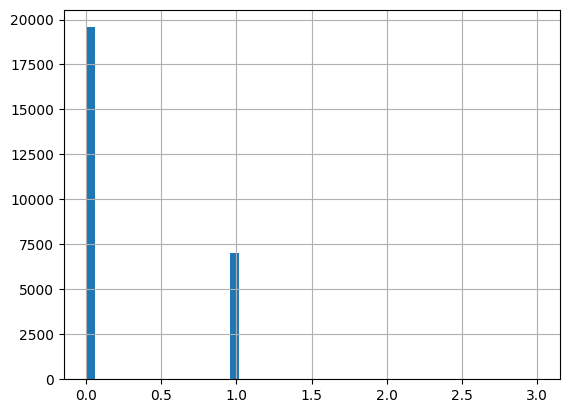

In [ ]:
print(pumps_df[pumps_df['population']<4].shape[0]/pumps_df.shape[0])
pumps_df[pumps_df['population']<4]['population'].hist(bins=50)
plt.show()

In [ ]:
#pumps by gps_height
# x=pumps_df.copy()
# x['gps_height_colour']=x['population'].apply(lambda x: 'red' if x==0 else ('purple' if x==1 else 'lightgreen'))

# f = folium.Figure(width=672, height=560)
# map = folium.Map(location=[-6.268373, 34.982544], zoom_start=6).add_to(f)

# for index, row in x.iterrows():
#   folium.Circle(location=(row['latitude'], row['longitude']),fill=True,color=row['gps_height_colour'],tooltip=(row['region'],row['lga'])).add_to(map)
# map

In [ ]:
x=pumps_df.copy()
x['population_filled']=x['population'].apply(lambda x: 'filled' if x>=4 else 'nan')
pivot=x.groupby(['region','lga','population_filled'])['id'].count().reset_index().pivot(index=['region','lga'],columns='population_filled',values='id').fillna(0).reset_index()
pivot['percentage']=pivot['nan']*100/(pivot['filled']+pivot['nan'])
pivot[pivot['percentage']>=60].sort_values(by=['percentage','nan'], ascending=False)

population_filled,region,lga,filled,nan,percentage
63,Mbeya,Rungwe,0.0,1106.0,100.000000
62,Mbeya,Mbozi,0.0,1034.0,100.000000
59,Mbeya,Kyela,0.0,859.0,100.000000
99,Shinyanga,Kahama,0.0,836.0,100.000000
101,Shinyanga,Maswa,0.0,809.0,100.000000
26,Kagera,Karagwe,0.0,771.0,100.000000
29,Kagera,Ngara,0.0,669.0,100.000000
19,Iringa,Makete,0.0,630.0,100.000000
77,Mwanza,Kwimba,0.0,627.0,100.000000
60,Mbeya,Mbarali,0.0,626.0,100.000000


In [ ]:
# Valores a imputar
pivot[pivot['percentage']>=60]['nan'].sum()

23953.0

In [ ]:
top_missing=pivot[pivot['percentage']>=60]['lga'].tolist()
grey_area=pivot[(pivot['percentage']>=40) & (pivot['percentage']<=60)]['lga']

In [ ]:
# pumps by location and subgroup
# x=pumps_df[pumps_df['lga'].isin(grey_area)].copy()
# # x=pumps_df[pumps_df['region']=='Iringa'].copy()
# x['gps_height_colour']=x['population'].apply(lambda x: 'red' if x==0 else ('purple' if x==1 else 'lightgreen'))

# f = folium.Figure(width=672, height=560)
# map = folium.Map(location=[-6.268373, 34.982544], zoom_start=6).add_to(f)

# for index, row in x.iterrows():
#   folium.Circle(location=(row['latitude'], row['longitude']),fill=True,color=row['gps_height_colour'],tooltip=row['population']).add_to(map)
# map

In [ ]:
# % de arreglo si se imputan los que tienen más del 60%
pivot[pivot['percentage']>=60]['nan'].sum()/pumps_df.shape[0]

0.41594457082327607

### Imputación promedio lga

Con fin de enriquecer nuestros datos descargamos una base de datos directamente de una organización de censo en Tanzania donde resumia la información del "national bureau of statistics tanzania"

https://www.citypopulation.de/en/tanzania/admin/


In [ ]:
lga_population=pivot[pivot['percentage']>=60].merge(lga_df[['lga','population']], on='lga', how='left')
lga_population['popu_mean']=lga_population['population']/(lga_population['filled']+lga_population['nan'])
mean_by_lga=lga_population[['lga','popu_mean']].set_index('lga')['popu_mean'].to_dict()

In [ ]:
pumps_df['population']=pumps_df['population'].apply(lambda x: np.nan if x<4 else x)

In [ ]:
pumps_df['population_mean']=pumps_df.apply(lambda x: (mean_by_lga[x['lga']] if x['lga'] in top_missing else x['population']) if np.isnan(x['population']) else x['population'], axis=1)

In [ ]:
#Check if worked
x=pumps_df.copy()
x['population_filled']=x['population_mean'].apply(lambda x: 'filled' if x>=4 else 'nan')
pivot=x.groupby(['region','lga','population_filled'])['id'].count().reset_index().pivot(index=['region','lga'],columns='population_filled',values='id').fillna(0).reset_index()
pivot['percentage']=pivot['nan']*100/(pivot['filled']+pivot['nan'])
pivot.sort_values(by=['percentage','nan'], ascending=False).head()

population_filled,region,lga,filled,nan,percentage
116,Tanga,Kilindi,73.0,88.0,54.658385
75,Mtwara,Tandahimba,121.0,145.0,54.511278
68,Morogoro,Mvomero,347.0,324.0,48.286140
49,Manyara,Kiteto,102.0,91.0,47.150259
33,Kigoma,Kigoma Urban,39.0,32.0,45.070423


In [ ]:
#Revisa si en los top missing aun hay valores nan
print('Valores con promedio imputados:',pumps_df[pumps_df['lga'].isin(top_missing)]['population'].isna().sum())
print('Nan values en los top missing:',pumps_df[pumps_df['lga'].isin(top_missing)]['population_mean'].isna().sum())

Valores con promedio imputados: 23953
Nan values en los top missing: 0


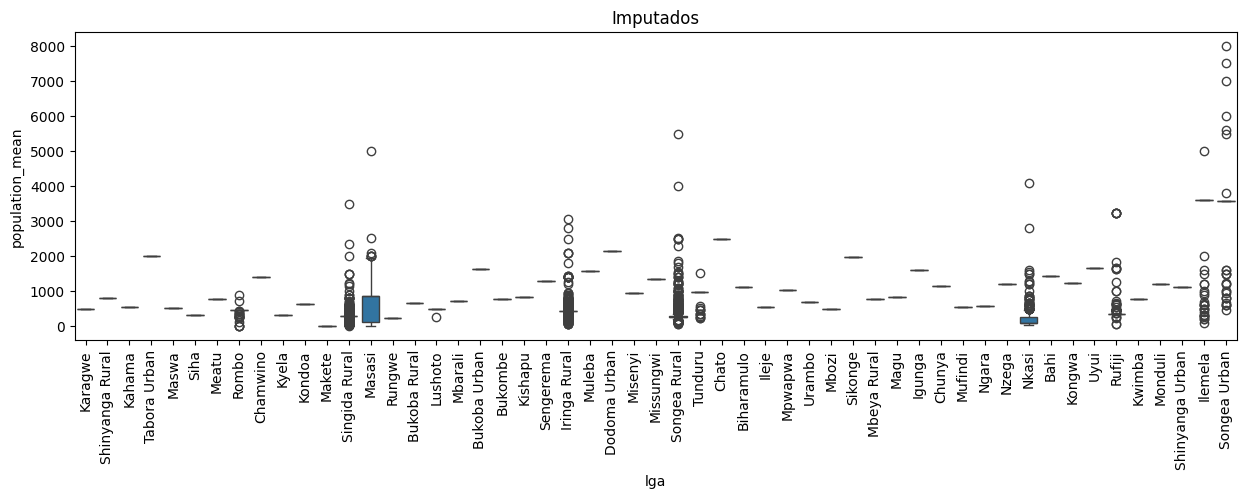

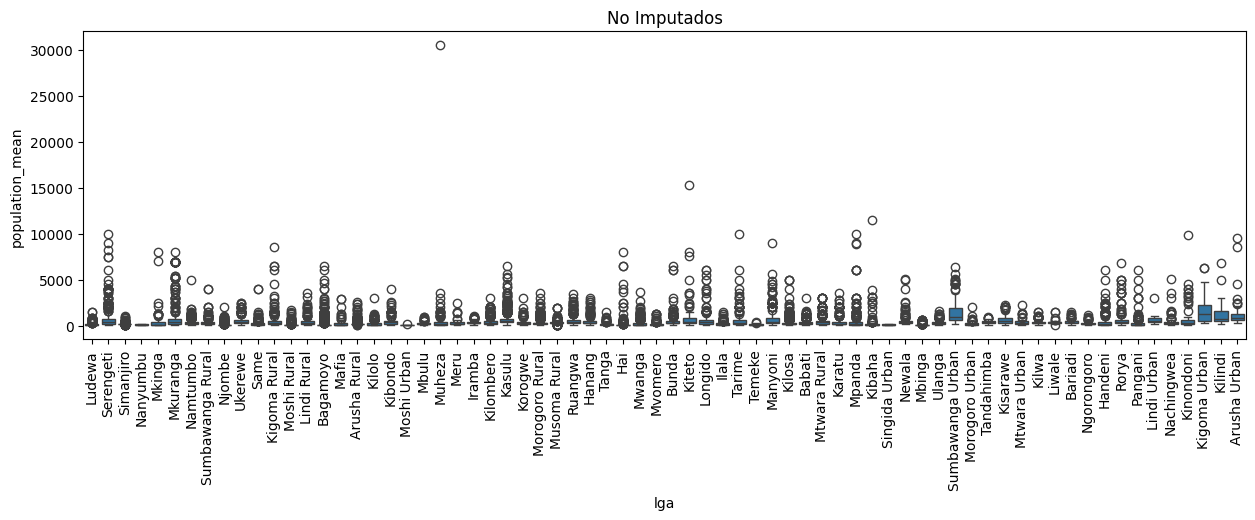

In [ ]:
plt.figure(figsize=(15, 4))
sns.boxplot(x=pumps_df[pumps_df['lga'].isin(top_missing)]['lga'],y=pumps_df[pumps_df['lga'].isin(top_missing)]['population_mean'])
plt.xticks(rotation=90)
plt.title('Imputados')
plt.show()

plt.figure(figsize=(15, 4))
sns.boxplot(x=pumps_df[pumps_df['lga'].isin(top_missing)==False]['lga'],y=pumps_df[pumps_df['lga'].isin(top_missing)==False]['population_mean'])
plt.xticks(rotation=90)
plt.title('No Imputados')
plt.show()

In [ ]:
# #Mapa de los lgas imputados
# x=pumps_df[(pumps_df['population_mean'].isna()==False) & (pumps_df['lga'].isin(top_missing))][['latitude','longitude','population_mean']].copy()
# f = folium.Figure(width=672, height=560)
# map = folium.Map(location=[-6.268373, 34.982544], zoom_start=6).add_to(f)
# colormap = linear.Blues_09.scale(pumps_df['population_mean'].quantile(.1), pumps_df['population_mean'].quantile(.9))

# for index, row in x.iterrows():
#   folium.Circle(location=(row['latitude'],row['longitude']), tooltip=row['population_mean'], fill=True,
#                 color=None, fill_color=colormap(row['population_mean']), fill_opacity=0.8).add_to(map)

# # Añadir la barra de colores al mapa
# colormap.caption = 'Population'
# colormap.add_to(map)
# # map.save("mapa_interactivo.html")
# map

In [ ]:
# #Mapa General
# x=pumps_df[pumps_df['population_mean'].isna()==False][['latitude','longitude','population_mean']].copy()
# f = folium.Figure(width=672, height=560)
# map = folium.Map(location=[-6.268373, 34.982544], zoom_start=6).add_to(f)
# colormap = linear.Blues_09.scale(pumps_df['population_mean'].quantile(.1), pumps_df['population_mean'].quantile(.9))

# for index, row in x.iterrows():
#   folium.Circle(location=(row['latitude'],row['longitude']), tooltip=row['population_mean'], fill=True,
#                 color=None, fill_color=colormap(row['population_mean']), fill_opacity=0.8).add_to(map)

# # Añadir la barra de colores al mapa
# colormap.caption = 'Population'
# colormap.add_to(map)
# # map.save("mapa_interactivo.html")
# map

In [ ]:
# #Mapa de los outliers
# q=pumps_df['population_mean'].quantile(.99)
# x=pumps_df[pumps_df['population_mean']>=10000][['latitude','longitude','population_mean']].copy()

# f = folium.Figure(width=672, height=560)
# map = folium.Map(location=[-6.268373, 34.982544], zoom_start=6).add_to(f)
# for index, row in x.iterrows():
#   folium.Circle(location=(row['latitude'],row['longitude']), tooltip=row['population_mean'], fill=True).add_to(map)

# map

### Imputación KNN

In [ ]:
imputer = KNNImputer(n_neighbors=3)
coso = imputer.fit_transform(pumps_df[pumps_df['lga'].isin(top_missing)==False][['population','longitude','latitude']])
coso

array([[109.        ,  34.93809275,  -9.85632177],
       [280.        ,  34.6987661 ,  -2.14746569],
       [250.        ,  37.46066446,  -3.82132853],
       ...,
       [125.        ,  37.16980689,  -3.25384746],
       [ 56.        ,  35.24999126,  -9.0706288 ],
       [150.        ,  38.10404822,  -6.74746425]])

In [ ]:
pumps_df['population_imputed']=pumps_df['population_mean']
pumps_df.loc[pumps_df['lga'].isin(top_missing)==False,'population_imputed'] = coso[:,0]

In [ ]:
#Comprobación de que funciono
pumps_df[(pumps_df['lga'].isin(top_missing)==False) & (pumps_df['population'].isna())][['population_mean','population_imputed']].head()

,population_mean,population_imputed
5,NaN,126.666667
19,NaN,196.666667
55,NaN,16.666667
69,NaN,1050.000000
74,NaN,712.666667


In [ ]:
#Revisa si aun hay valores nan
pumps_df['population_imputed'].isna().sum()

0

In [ ]:
#Elimina columnas usadas pero no utiles para el modelo
pumps_df = pumps_df.drop(['population','population_mean','lga'], axis=1)

## GPS_height Cleaning

In [ ]:
pumps_df['gps_height'].isnull().sum()/pumps_df.shape[0]

0.0

In [ ]:
altitud_df=pd.read_csv('altitudes.csv')
pumps_df = pumps_df.merge(altitud_df[['id','altitud']], how = 'left', on = ['id'])
pumps_df['altitud'] = pumps_df.apply(lambda x: x['gps_height'] if np.isnan(x['altitud']) else x['altitud'], axis=1)
pumps_df = pumps_df.drop(['gps_height'], axis=1)

In [ ]:
x=pumps_df[['latitude','longitude','altitud']].copy()
f = folium.Figure(width=672, height=560)
map = folium.Map(location=[-6.268373, 34.982544], zoom_start=6).add_to(f)
colormap = linear.YlOrRd_09.scale(pumps_df['altitud'].min(), pumps_df['altitud'].max())

for index, row in x.iterrows():
  folium.Circle(location=(row['latitude'],row['longitude']), tooltip=row['altitud'], fill=True, color=None, fill_color=colormap(row['altitud']), fill_opacity=0.8).add_to(map)

# Añadir la barra de colores al mapa
colormap.caption = 'Altura (m)'
colormap.add_to(map)

# map.save("mapa_interactivo.html")
map

Output hidden; open in https://colab.research.google.com to view.

## Source Cleaning

La variable source tiene dos tipos unkown y others que en esencia me dan la misma información. Y es que al no saber preferimos dejarlo solo en unknown.

In [ ]:
pumps_df['source'] = pumps_df['source'].replace({'other': 'unknown'})
pumps_df['source'].value_counts()


,count
source,
spring,17006
shallow well,15498
machine dbh,10826
river,9612
rainwater harvesting,2218
hand dtw,873
dam,649
lake,639
unknown,266


## Construction year Cleaning

In [ ]:
pumps_df['construction_year']=pumps_df['construction_year'].replace(0,np.nan)
print(pumps_df['construction_year'].isna().sum()/pumps_df.shape[0])

0.32812961258617396


El 34% de los registros en la columna construction_year es 0. Debido a la amplia variedad de años de construcción, no vamos a utilizar únicamente la media general.

In [ ]:
pumps_df['construction_year'].min(),  pumps_df['construction_year'].max() , pumps_df['construction_year'].mean()

(1960.0, 2013.0, 1996.8146855857951)

Podemos observar que la media del año de construcción por grupo de tipo de extracción proporciona información mucho más detallada.

In [ ]:
# Promedio del año de extracción por grupo de tipo de extracción
mean_construction = pumps_df.groupby('extraction_type_group')['construction_year'].mean().reset_index()
mean_construction['construction_year']=mean_construction['construction_year'].round()
mean_construction=mean_construction.rename(columns={"construction_year": "imputed_construction_year"})
mean_construction

,extraction_type_group,imputed_construction_year
0,afridev,2002.0
1,gravity,1996.0
2,india mark ii,2001.0
3,india mark iii,2004.0
4,mono,1993.0
5,nira/tanira,1999.0
6,other,1993.0
7,other handpump,2001.0
8,other motorpump,2012.0
9,rope pump,2006.0


Usar solo la media general podría resultar engañoso debido a la variabilidad en los años de construcción. Esta variación amplia hace que la media general no refleje las particularidades de cada grupo de tipo de extracción. Al calcular la media de los años de construcción para cada grupo específico, obtenemos una visión más precisa de las diferencias entre ellos, lo que permite realizar análisis y comparaciones más significativas.

In [ ]:
# Se hace merge y se reemplazan valores faltantes
pumps_df = pumps_df.merge(mean_construction, how='left', on='extraction_type_group')
pumps_df['construction_year_imputed'] = np.where(pumps_df['construction_year'].isna(), pumps_df['imputed_construction_year'], pumps_df['construction_year'])

# Eliminar columnas adicionales
pumps_df = pumps_df.drop(['imputed_construction_year', 'construction_year'], axis=1)

In [ ]:
pumps_df['construction_year_imputed'].value_counts(normalize=True).head(10)

,proportion
construction_year_imputed,
1996.0,0.130880
1999.0,0.113984
1993.0,0.074253
2010.0,0.045931
2008.0,0.045375
2009.0,0.043986
2000.0,0.036310
1997.0,0.032907
2002.0,0.030649


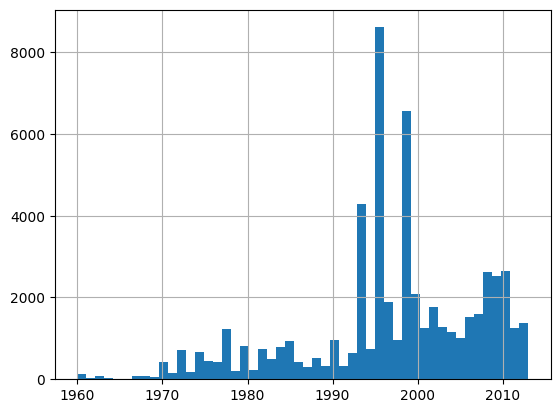

In [ ]:
pumps_df['construction_year_imputed'].hist(bins=50)
plt.show()

## Scheme management Cleaning

Considerando que existe una gran superposición en los datos entre 'management' y 'scheme_management', se procede a imputar los valores faltantes de 'scheme_management' usando la moda de la combinación 'management - scheme_management'. Esto significa que, para cada grupo de 'management', vamos a buscar el valor más común (la moda) de 'scheme_management' y utilizaremos ese valor para rellenar los datos faltantes.

In [ ]:
sm_df = pumps_df.groupby([  'management_group', 'scheme_management' , 'management'])['id'].count().reset_index()
sm_df = sm_df.sort_values('management')
sm_df.head(10)

,management_group,scheme_management,management,id
0,commercial,Company,company,674
21,commercial,WUG,company,4
19,commercial,WUA,company,1
15,commercial,VWC,company,2
7,commercial,Private operator,company,2
11,commercial,Trust,company,1
35,other,WUA,other,2
31,other,Private operator,other,4
33,other,VWC,other,49
36,other,WUG,other,15


In [ ]:
scheme_mode = pumps_df.groupby(['management'])['scheme_management'].agg(pd.Series.mode).reset_index()
scheme_mode = scheme_mode.rename(columns={"scheme_management": "imputed_scheme_management"})
scheme_mode

,management,imputed_scheme_management
0,company,Company
1,other,Other
2,other - school,SWC
3,parastatal,Parastatal
4,private operator,Private operator
5,trust,Trust
6,unknown,VWC
7,vwc,VWC
8,water authority,Water authority
9,water board,Water Board


In [ ]:
# Se hace merge y se reemplazan valores faltantes
pumps_df = pumps_df.merge(scheme_mode, how = 'left', on = [ 'management'])
pumps_df['scheme_management_imputed'] = np.where(pumps_df['scheme_management'].isna(), pumps_df['imputed_scheme_management'], pumps_df['scheme_management'])

# Eliminar columnas adicionales
pumps_df = pumps_df.drop(['scheme_management', 'imputed_scheme_management','scheme_name'],axis=1)

## Permit Cleaning

Se procede a imputar los valores faltantes usando la moda (ya que el 69% de las bombas tienen un permiso), optaremos por utilizar la moda de esta variable considerando las columnas 'public_meeting' y 'management_group'. Esto significa que, para cada combinación de 'public_meeting' y 'management_group', imputaremos los valores faltantes de 'permit' usando el valor más común de esa combinación específica. De esta manera, realizaremos una imputación más precisa basada en los patrones observados en los datos.

In [ ]:
public_meeting = pumps_df.groupby(['public_meeting','management_group' ,'permit'])['id'].count().reset_index()
pivot = public_meeting.pivot(index = ['public_meeting', 'management_group', ], columns = 'permit')

mi = pivot .columns
mi.tolist()
ind = pd.Index([ str(e[1])  for e in mi.tolist()])
pivot .columns = ind

pivot['total_permit'] = pivot['False'] + pivot['True']
pivot['has permit'] = round((pivot['True'] /pivot['total_permit'])*100,1)
pivot

False   True  total_permit  has permit
public_meeting management_group                                        
False          commercial          237    535           772        69.3
               other                12    296           308        96.1
               parastatal          212    132           344        38.4
               unknown              28     57            85        67.1
               user-group         1714   1285          2999        42.8
True           commercial          508   1885          2393        78.8
               other               166    248           414        59.9
               parastatal          243    697           940        74.1
               unknown              44    148           192        77.1
               user-group        12359  31020         43379        71.5

In [ ]:
# Se hace merge y se reemplazan valores faltantes
permit_mg_mode = pumps_df.groupby(['public_meeting', 'management_group'])['permit'].agg(pd.Series.mode).reset_index()
permit_mg_mode = permit_mg_mode .rename(columns={"permit": "imputed_permit_mg"})
pumps_df = pumps_df.merge(permit_mg_mode, how = 'left', on = ['public_meeting', 'management_group'])

# Si falta el valor de 'permit', se reemplaza usando la moda de la combinación 'public_meeting - management_group'. Si falta 'public_meeting' o 'management_group', entonces se usa la moda de 'permit' (True)
pumps_df['permit_imputed'] = np.where(pumps_df['permit'].isna(), pumps_df['imputed_permit_mg'], pumps_df['permit'])
pumps_df['permit_imputed']  = np.where(pumps_df['permit_imputed'] .isna(), pumps_df['permit'].mode(), pumps_df['permit_imputed'])

# Eliminar columnas adicionales
pumps_df = pumps_df.drop(['permit','public_meeting','imputed_permit_mg','management_group'], axis=1)

## Extraction type class Cleaning


Vamos a mantener la columna 'extraction_type_class' y agruparemos los valores de 'extraction_type_group' en categorías más amplias para simplificar el análisis.

In [ ]:
pumps_df.groupby(['extraction_type_class', 'extraction_type_group', 'extraction_type'])['id'].count().reset_index()

,extraction_type_class,extraction_type_group,extraction_type,id
0,gravity,gravity,gravity,26696
1,handpump,afridev,afridev,1659
2,handpump,india mark ii,india mark ii,2284
3,handpump,india mark iii,india mark iii,91
4,handpump,nira/tanira,nira/tanira,7360
5,handpump,other handpump,other - mkulima/shinyanga,2
6,handpump,other handpump,other - play pump,85
7,handpump,other handpump,other - swn 81,229
8,handpump,other handpump,walimi,20
9,handpump,swn 80,swn 80,3448


Aplicaremos las siguientes agrupaciones:

* 'swn 80' y 'swn 81' se convertirán en 'swn'.
* 'cemo' y 'climax' se agruparán bajo 'other motorpump'.
* 'other - mkulima', 'other - play' y 'walimi' se convertirán en 'other handpump'.

Estas agrupaciones nos ayudarán a reducir la cantidad de categorías únicas en 'extraction_type', lo que facilitará el análisis manteniendo la información relevante.

In [ ]:
swn = ['other - swn 81', 'swn80']
pumps_df['extraction_type'] = np.where(pumps_df['extraction_type'].isin(swn), 'swn',  pumps_df['extraction_type'])

other_handpump = ['other - mkulima/shinyanga', 'other - play pump', 'other - walimi']
pumps_df['extraction_type']= np.where(pumps_df['extraction_type'].isin(other_handpump), 'other handpump',  pumps_df['extraction_type'])

other_motorpump = ['cemo', 'climax']
pumps_df['extraction_type'] = np.where(pumps_df['extraction_type'].isin(other_motorpump), 'other motorpump',  pumps_df['extraction_type'])

# Eliminar columnas adicionales
pumps_df = pumps_df.drop(['extraction_type_class', 'extraction_type_group'], axis=1)

## Import GDP per capita

In [ ]:
region_gdp=pd.read_csv("gdp_per_capita.csv")
gdp_dic=region_gdp.set_index('region')['gdp_per_capita'].to_dict()

In [ ]:
pumps_df['gdp_per_capita']=pumps_df['region'].map(gdp_dic)
pumps_df['gdp_per_capita'].isna().sum()

0

# Export pumps_cleaned


In [ ]:
pumps_df.shape

(57587, 18)

In [ ]:
# ruta_carpeta = '/content/drive/MyDrive/Maestria Andes/Applied data science/Proyecto DS 2024/Data'
ruta_carpeta = '/content/drive/MyDrive/Proyecto DS 2024/Data'
pumps_df.to_csv(f'{ruta_carpeta}/pumps_cleaned.csv', index=False)